In [9]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import re
import string
from nltk.corpus import stopwords as nltk_stopwords
import wordcloud
from sklearn.model_selection import train_test_split
import keras
from keras.models import load_model
from gensim.corpora import Dictionary
from keras.layers import Dense, LSTM, Bidirectional, Input, Dropout, Embedding
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


In [10]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!tar -xzf glove.twitter.27B.zip
!tar -xzf training.1600000.processed.noemoticon.rar
!tar -xzf model_hidden_512_dropout_0.7_test_size_0.1_unlemmatized.rar

# Introduction
Sentiment analysis is a fundamental natural language processing that consists of automating the detection of the sentiment conveyed by language. This has useful business applications, like automating the review of online business reviews. 

Here, a model using an LSTM is trained to determine whether tweets convey positive or negative sentiment.

# Load Data
Note that in terms of features, only polarity and the tweet text are kept, since the other features are unnecessary.

In [11]:
columns = ['polarity', 'date', 'tweet_id', 'query_flag', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', names=columns)

# Only need text and polarity
df = df[['polarity', 'text']]
print('Shape: ', df.shape)


df.head()

Shape:  (1600000, 2)


,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
X = df['text'].values
y = df['polarity'].values

# Text Preporcessing
Text cleaning here consists of removing usernames, removing urls, removing punctuation, removing short words and stop words, and tokenizing text. With the exception of tokenization, the goal of preprocessing is to remove unnecessary information from the corpus. For example, URLs, usernames, punctuation and shorter words are unlikely to communicate sentiment. Strictly speaking, none of those steps are necessary. On the other hand, tokenization, splitting a string into atomic units, is absolutely necessary for analysis, as it allows strings to be converted into vectors in which each comnponent represents a word.

One potential preprocessing step not used here is lemmatization - reducing a word to its base form such as "ran" to "run." Empirically, I found lemmatization did not help on this problem, and depending on the amount of text under analysis, it can slow down sentiment predictions a noticeable amount since it requires both part of speech tagging and lemmatization.

## Remove Usernames

In [13]:
X_no_user = []

for tweet in X:
    X_no_user.append(re.sub('\@[a-zA-Z0-9]*', '', tweet))

In [14]:
print('Before removing usernames')
print(X[500])
print('After removing usernames')
print(X_no_user[500])

Before removing usernames
@Anistorm Sorry 
After removing usernames
 Sorry 


## Check for and remove URLs

In [15]:
all_urls = []
for tweet in X_no_user:
    # Checks for url in tweet
    all_urls.append(re.search('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', tweet))

# Turns a list of regex match results into a list of urls
all_urls = [match.group(0) for match in all_urls if match]

print(f'There are {len(all_urls)} urls in the dataset.')

There are 70046 urls in the dataset.


These URLs are removed.

In [16]:
X_no_url = []

for tweet in X_no_user:
    X_no_url.append(re.sub('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', tweet))

## Remove Punctuation

In [17]:
punctuation = string.punctuation + '@'
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~@'

In [18]:
X_no_punct = []
for tweet in X_no_url:
    X_no_punct.append(''.join([char for char in tweet if char not in punctuation]))

## Tokenization

In [19]:
X_tokenized = [word_tokenize(tweet) for tweet in X_no_punct]

## Short and stopword removal
Stopwords are words that do not really carry much or any meaning, such as "you," "a," or "and." Similarly, short "words," defined here as a word made of 2 or fewer characters, are unlikely to carry any meaning. Additionally, filtering out short words may catch things that are not words at all, like the D in the tweet above.

Additionally, during this step, tokens are converted to lowercase to decrease the number of unique characters and ensure that a model recognizes, for example, 'word' and 'Word' as the same word.

In [20]:
stopwords = nltk_stopwords.words('english')

In [21]:
X_no_stopwords = []
for tweet in X_tokenized:
    X_no_stopwords.append([tok.lower() for tok in tweet if tok not in stopwords and len(tok) > 3])

In [22]:
print(X_no_stopwords[0])

['awww', 'thats', 'bummer', 'shoulda', 'david', 'carr', 'third']


# Recategorize Tweets
Positive tweets are encoded to have a target value of 1. Negative tweets are encoded to have a value of 0. Neutral tweets are removed.

In [23]:
X_clean = []
y_clean = []
for i, polarity in enumerate(y):
    if polarity < 2:
        y_clean.append(0)
        X_clean.append(X_no_stopwords[i])
    elif polarity > 2:
        y_clean.append(1)
        X_clean.append(X_no_stopwords[i])

In [24]:
df.polarity = y_clean
df.text = X_clean

In [25]:
df.head()

,polarity,text
0,0,"[awww, thats, bummer, shoulda, david, carr, th..."
1,0,"[upset, cant, update, facebook, texting, might..."
2,0,"[dived, many, times, ball, managed, save, rest..."
3,0,"[whole, body, feels, itchy, like, fire]"
4,0,"[behaving, cant]"


# Exploratory Data Analysis

## Class Balance

In [26]:
positive_tweets = np.sum(y_clean)
print(f'There are {positive_tweets} positive tweets, accounting for {100*np.round(positive_tweets/len(y_clean), decimals=2)}% of tweets')

There are 800000 positive tweets, accounting for 50.0% of tweets


In [27]:
unique_polarities = df['polarity'].unique()
print(f'The dataset had the following unique polarities {unique_polarities}.')

The dataset had the following unique polarities [0 1].


As shown above, the dataset only ever contained two polarities.

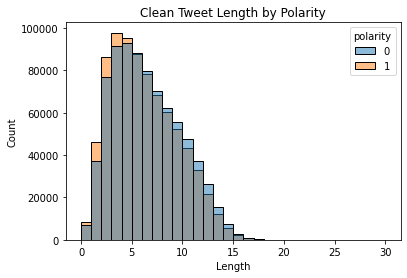

In [28]:
sns.histplot(data=df, x=[len(tweet) for tweet in df.text.values], bins=30, hue='polarity')
plt.title('Clean Tweet Length by Polarity')
plt.xlabel('Length')
plt.show()

## Word Clouds
The word cloud allows visualization of common words. Larger words are used more frequently. Below, word clouds for each sentiment are presented.

### Positive Sentiment

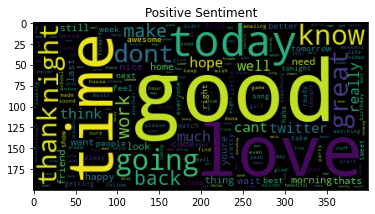

In [29]:
positive_text = ''
for tweet in df[df['polarity'] == 1]['text'].values:
    positive_text += ' '.join(tweet)
wc = wordcloud.WordCloud(collocations=False)
wc.generate(positive_text)
plt.title('Positive Sentiment')
plt.imshow(wc)
plt.show()

Words suggesting positivity are shown prominently above, like "good," "great," "love," etc.

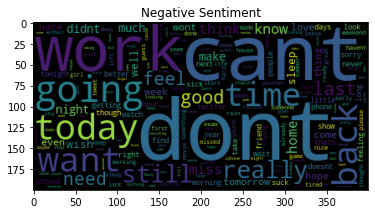

In [30]:
negative_text = ''
for tweet in df[df['polarity'] == 0]['text'].values:
    negative_text += ' '.join(tweet)
wc = wordcloud.WordCloud(collocations=False)
wc.generate(negative_text)
plt.title('Negative Sentiment')
plt.imshow(wc)
plt.show()

The word cloud for negative sentiment has negative words like "dont" and "cant." However, it also contains positive words like "good," suggesting some vocabulary cross contamination. Words are likely to appeaar in both datasets, but this suggests that a custom stopword list may improve model performance.

## Split Data

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.1, random_state=123)

# Vectorize Text
Neural networks need text input to be converted to numerical representations. Therefore, the text must be vectorized. This consists of three steps: padding, initial vectorization, and embedding.

The padding step ensures that each sequence of tokens is the same length by padding each sequence with a "[PAD]" token as necessaary until all of the sequences of tokens are the same length. This ensures that ultimately all of the sequences have the same dimensionality, which is necessary to use the model.

The initial vectorization converts each list of tokens into a list of indices, where each index represents a token. The model will only accept numerical values, so this step is necessary. However, each index is assigned to a word in an arbitrary fashion.

The embedding step converts lists of arbitrary indices into lists of vectors in a semantically meaningful vector space, where each vector represents a token. In other words, while the indices are arbitrary, the embedding vectors should have mathematical relationships that analogize to semantic relationships between words. To do this, an embedding layer is created using Stanford's GloVe vectors. Specifically, 100 dimensional vectors created by training on tweets are used. Creating these vectors is computationally very expensivee, which is why pretrained vectors are used. A caveat must be made: semantically meaningful vectors can only be guaranteed for words present in the GloVe vectors.

## Pad Tweets

In [32]:
# Takes in clean, tokenized tweets
# Returns tweets padded to the length of the longest cleaned tweet
def pad_sequences(tweets, max_len = 0):
    padded_tweets = []
    if max_len > 0:
        seq_len = max_len
    else:
        seq_len = max([len(tweet) for tweet in tweets])
    for tweet in tweets:
        while len(tweet) < seq_len:
            tweet.append('[PAD]')
        padded_tweets.append(tweet)
    return padded_tweets

xtrain_padded = pad_sequences(x_train)
x_test_padded =  pad_sequences(x_test, max_len=len(xtrain_padded[0]))

In [33]:
# Takes in a list of padded tweets. When vectorizing the test set, reuse the
# dictionary used on the training set.
# Returns vectorized tweets and the dictionary used to vectorize the tweets
def vectorize_tweets(tweets, test_set=False, train_dict=None):
    if test_set:
        dictionary= train_dict
    else:
        dictionary = Dictionary(tweets)
    vectorized_tweets = [dictionary.doc2idx(tweet) for tweet in tweets]
    return np.asarray(vectorized_tweets), dictionary
   
xtrain_vectorized, train_dict = vectorize_tweets(xtrain_padded)
x_test_vectorized, _ = vectorize_tweets(x_test_padded, test_set=True, train_dict=train_dict)

# Create GloVe Embedding Matrix
Used the 100d glove vectors

In [34]:
path_to_glove_file = ('glove.twitter.27B.100d.txt')

embeddings_index = {}
with open(path_to_glove_file, encoding='utf8') as f:
    for line in f:
        word, vec = line.split(maxsplit=1)
        vec = np.fromstring(vec, 'f', sep=' ')
        embeddings_index[word] = vec
        
print(f'Found {len(embeddings_index)} word vectors')

Found 1193514 word vectors


In [35]:
embedding_dim = 100
vocab_size = len(train_dict)
hits = 0
misses = 0
missing = []

tok2id_items = list(train_dict.token2id.items())
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for tok, i in tok2id_items:
    embedding_vector = embeddings_index.get(tok)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        missing.append(tok)
        misses += 1
        
print(f'Successfully converted {hits} English words with {misses} not found.')

Successfully converted 115564 English words with 300286 not found.


## Create Embedding Layer

In [36]:
embedding_layer = Embedding(vocab_size,
                               embedding_dim,
                              weights=[embedding_matrix],
                              trainable=False,
                              )

# Build Model
The model used consists of an embedding layer, a bidirectional LSTM, and two dense layers, with dropout layers and recurrent dropout used to prevent overfitting. The embedding layer embeds the lists of indices in a semantically meaaningful vector space. An LSTM is used since text is sequential data; each word is not independent of the previous or following word. Conceptually, an LSTM allows the model to consider sequences of data as sequences, rather than as a sort of list of discrete and unrelated data points. The bidirectional LSTM allows the model to see the text both forwards and in reverse. The dense layers are used for classification.

In [37]:
seq_len = xtrain_vectorized.shape[1]
hidden_size = 512
dropout_rate = 0.7

In [38]:
# Takes in hyperparameters and the length of the model input sequences
# Returns a model
def build_model(seq_len, hidden_size, dropout_rate):
    # Input
    inputs = Input(shape=(seq_len,))
    
    embed = embedding_layer(inputs)

    lstm = Bidirectional(LSTM(hidden_size, recurrent_dropout=dropout_rate))(embed)

    drop = Dropout(dropout_rate)(lstm)

    dense = Dense(hidden_size, activation='relu')(drop)

    drop = Dropout(dropout_rate)(dense)

    outputs = Dense(1, activation='sigmoid')(drop)

    model = Model(inputs, outputs)
    return model

## Train Model

In [39]:
test_size = '0.1'

folder_name = f'model_hidden_{hidden_size}_dropout_{dropout_rate}_test_size_{test_size}_unlemmatized'


if folder_name in os.listdir():
    model = load_model(folder_name)
    print(model.summary())

else:
    # Building the model
    model = build_model(seq_len, hidden_size, dropout_rate)
    print(model.summary())
    opt = Adam()
    es = EarlyStopping(monitor='val_loss',
                    min_delta=0.001,
                    patience=5,
                    mode='min',
                    verbose=1,
                    restore_best_weights=True)
    checkpoint = ModelCheckpoint('tmp/checkpoint',
                        monitor='val_loss',
                        save_best_only=False,
                        save_weights_only=False,
                        save_freq='epoch',
                        
                        )
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    # Fitting the model
    history = model.fit(xtrain_vectorized, np.asarray(y_train),
                    batch_size=256,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[es, checkpoint])
    # Save Model
    model.save(folder_name)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 100)           41585000  
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             2510848   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

# Evaluation
The model is evaluated on the test set. To evaluate the model, accuracy (the portion of samples correctly identified as either positive or negative in sentiment) is used as a summarizing metric. The precision (portion of positive class identifications which were true positive) and recall (portion of class samples correctly identified) are presented for each class.

In [40]:
np.asarray(x_test_vectorized)

array([[  224,   762,  2465, ...,     0,     0,     0],
       [  351,   688,  1267, ...,     0,     0,     0],
       [ 1409,    -1,   600, ...,     0,     0,     0],
       ...,
       [  994,    48,   346, ...,     0,     0,     0],
       [37920,  1267, 28949, ...,     0,     0,     0],
       [   -1,    43,   600, ...,     0,     0,     0]])

In [41]:
y_pred = model.predict(x_test_vectorized)
y_pred = np.round(y_pred)

In [46]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.80      0.77      0.78     80047
    Positive       0.78      0.80      0.79     79953

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



The model has an accuracy of 79%, i.e. it correctly classifies 79% of samples. Regarding the tweets with negative sentiments, the model correctly classified 78% of samples. On this class, it achieved a precision of 0.80 and recall of 0.77, meaning that 80% of samples identified as negative in sentiment were actually negative, and 77% of samples that were negative in sentiment were identified as such. With respect to positively identified samples, the model accurately identified 79% of samples and achieved a precision of 0.78 and recall of 0.80.

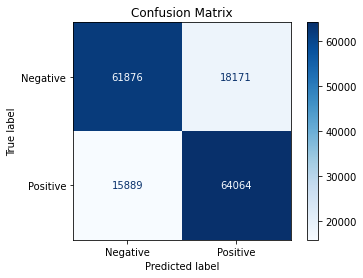

In [43]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', )
plt.title('Confusion Matrix')
plt.show()

The confusion matrix effectively fontains the same information as the table above it, but it presents the absolute numbers of counts from which the accuracy, precision, and recall are calculated.

# Example Predictions

In [47]:
'''
Takes a string or list of strings and returns a tokenized string or list of strings with usernames,
URLs, punctuation and stopwords removed.
Takes a string or list of strings as arguments.
Returns a clean list (of lists) of tokens.
'''
def clean_text(text):
    text_clean = []

    if type(text) == str:
        text = [text]
    for sentence in text:
        sent_no_user = re.sub('\@[a-zA-Z0-9]*', '', sentence)
        sent_no_url = re.sub('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', sent_no_user)
        sent_no_punct = ''.join([char for char in sent_no_url if char not in punctuation])
        sent_tokenized = word_tokenize(sent_no_punct)
        sent_no_stopwords = [tok.lower() for tok in sent_tokenized if tok not in stopwords and len(tok) > 3]
        text_clean.append(sent_no_stopwords)

        
    return text_clean

'''
Vectorizes tokenized texts by padding them and converting them to lists of indices.
Takes a list of tokenized texts as arguments as well as an optional maximum padding lenth.
Returns a list of vectors.
'''
def vectorize_text(text, max_len=x_test_vectorized.shape[1]):
    text_padded = pad_sequences(text, max_len=max_len)
    text_vectorized, _ = vectorize_tweets(text_padded, test_set=True, train_dict=train_dict)
    return text_vectorized

'''
Predicts the sentiment of a string or list of strings.
Takes a string or list of strings as arguments.
Returns a list of sentiments
'''
def predict_sentiment(text, max_len=x_test_vectorized.shape[1]):
    sentiment_dict = {0:'Negative', 1:'Positive'}
    text_clean = clean_text(text)
    text_vectorized = vectorize_text(text_clean, max_len=max_len)

    y_pred = model.predict(text_vectorized)
    y_pred = np.round(y_pred)

    y_pred = [sentiment_dict[prediction[0]] for prediction in y_pred]

    return y_pred


In [49]:
examples = ['He is happy',
            'He is sad',
            'He is unhappy',
            'The product selection is excellent',
            'They never have what I want in stock',
            'I would go to this location again',
            'The store was busy',
            'The service was really bad',
            'The lines were really long',
            'The office closes early',
            'Great prices']

predictions = predict_sentiment(examples)

for i in range(len(examples)):
    print(f'{examples[i]}: {predictions[i]}')

He is happy: Positive
He is sad: Positive
He is unhappy: Negative
The product selection is excellent: Positive
They never have what I want in stock: Negative
I would go to this location again: Positive
The store was busy: Negative
The service was really bad: Negative
The lines were really long: Negative
The office closes early: Negative
Great prices: Positive


Note that with the exception of "He is sad" the model correctly identifies all of the sentences. The exception, "I am sad," is misclassified since all of the words in the sentence are "short" words. An easy solution is to change what is considered a "short" word or, less conveniently, to create a list of words to exclude from the definition of short words.

# Conclusion
The model performs well on the test set, with an accuracy of 79%. Next steps may include using a custom stopword list, retraining the model with more short words included in the corpus, contraction mapping, or a more complex model.